# Implementation of Variational AutoEncoder (VAE)

     VAE from "Auto-Encoding Variational Bayes" (2014, D.P. Kingma et. al.)
    
     Kernel-author: Jackson Kang @ Deep-learning Lab. (Handong Global University, S.Korea)
     
     Author-email:  mskang@handong.edu

     python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [2]:
import torch
import torch.nn as nn

import numpy as np

from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt

In [4]:
# Model Hyperparameters

dataset_path = Path.cwd().joinpath('data/pixelchars')

cuda = True
DEVICE = torch.device("cuda" if cuda else "cpu")
DEVICE =  torch.device("cpu")

batch_size = 100

hidden_dim = 400
latent_dim = 200

lr = 1e-3

epochs = 30

In [5]:
dataset_path

WindowsPath('B:/DHBW/learning_ai/VAE/data/pixelchars')

###    Step 1. Load (or download) Dataset

In [6]:
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder


mnist_transform = transforms.Compose([
        transforms.Resize([224,224]), # Resizing the image as the VGG only take 224 x 244 as input size
        transforms.Grayscale(3),
        transforms.ToTensor()
])

kwargs = {'num_workers': 1, 'pin_memory': True} 


if False:
    #torch.Size([100, 3, 28, 28])
    train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=False)
    test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=False)

else:
    # torch.Size([100, 3, 64, 64])
    data = ImageFolder(root=dataset_path, transform=mnist_transform)
    n = len(data)
    train_dataset, test_dataset = torch.utils.data.random_split(data, 
                                                    [int(n//100*70), int(n//100*30) + int(n%100)],
                                                    generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, **kwargs)
test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

In [7]:
train_loader

In [8]:
import torchvision
def imshow(img, idx=[100, 200, 50, 200]):
    fig = plt.figure()
    #img = img / 2 + 0.5     # unnormalize
    try:
        npimg = img.cpu().numpy()
    except:
        npimg = img.numpy()
    
    
    print(npimg.shape)
    print(np.transpose(npimg, (1, 2, 0)).shape)
        
    plt.imshow(np.transpose(npimg, (1, 2, 0))[idx[0]:idx[1], idx[2]:idx[3], :])
    #plt.imshow(npimg)
    fig.savefig('temp.svg')
    plt.show()

torch.Size([100, 3, 224, 224])
(3, 2940, 1810)
(2940, 1810, 3)


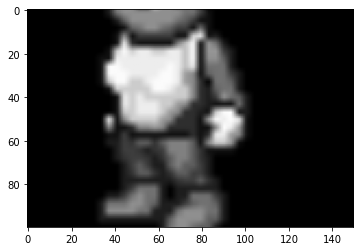

In [9]:
# Test Batch ziehen und Dims berechnen
dataiter = iter(test_loader)

images, labels = dataiter.next()
print(images.shape)
imshow(torchvision.utils.make_grid(images))

In [10]:
x_dim = np.prod(images.shape[1:])

In [11]:
(images.shape)

torch.Size([100, 3, 224, 224])

### Step 2. Define our model: Variational AutoEncoder (VAE)

In [12]:
class Encoder(nn.Module):
    """
    A simple implementation of Gaussian MLP Encoder and Decoder
    """
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.LeakyReLU(self.FC_input(x))    #TODO: Look here for fix??
        h_       = self.LeakyReLU(self.FC_input2(h_))
        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        
        return mean, log_var

In [13]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.LeakyReLU(self.FC_hidden(x))
        #print(h.shape)
        h     = self.LeakyReLU(self.FC_hidden2(h))
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [14]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

In [15]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)

#encoder = VGG_Encoder()

decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

### Step 3. Define Loss function (reprod. loss) and optimizer

In [16]:
from torch.optim import Adam

BCE_loss = nn.BCELoss()

def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

### Step 4. Train Variational AutoEncoder (VAE)

In [ ]:
print("Start training VAE...")
model.train()

for epoch in range(epochs):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        if x.shape[0] != batch_size:
            continue
        
        #x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

### Step 5. Generate images from test dataset

In [ ]:
model.eval()

with torch.no_grad():
    for batch_idx, (x, _) in enumerate(tqdm(test_loader)):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)
        
        x_hat, _, _ = model(x)


        break

In [ ]:
def show_image(x, idx):
    x = x.view(batch_size, 3, 64, 64)

    fig = plt.figure()
    plt.imshow(x[idx].cpu().numpy())

In [ ]:
labels

In [ ]:
x = x.reshape((100, 3, 64, 64))
print(x.shape)
imshow(torchvision.utils.make_grid(x))
#show_image(x, idx=0)

In [ ]:
x_hat = x_hat.reshape((100, 3, 64, 64))
print(x_hat.shape)
imshow(torchvision.utils.make_grid(x_hat))
#show_image(x_hat, idx=0)

### Step 6. Generate image from noise vector

**Please note that this is not the correct generative process.**

* Even if we don't know exact p(z|x), we can generate images from noise, since the loss function of training VAE regulates the q(z|x) (simple and tractable posteriors) must close enough to N(0, I). If q(z|x) is close to N(0, I) "enough"(but not tightly close due to posterior collapse problem), N(0, I) may replace the encoder of VAE.

* To show this, I just tested with a noise vector sampled from N(0, I) similar with Generative Adversarial Network.

In [ ]:
with torch.no_grad():
    noise = torch.randn(batch_size, latent_dim).to(DEVICE)
    generated_images = decoder(noise)

In [ ]:
generated_images = generated_images.reshape((100, 3, 64, 64))
save_image(generated_images.view(batch_size, 3, 64, 64), 'generated_sample.png')

In [ ]:
#show_image(generated_images, idx=12)
imshow(torchvision.utils.make_grid(generated_images))

In [ ]:
imshow(torchvision.utils.make_grid(generated_images), idx=[0, 100, 0, 100])

In [ ]:
imshow(torchvision.utils.make_grid(generated_images), idx=[200, 300, 200, 300])

In [ ]:
show_image(generated_images, idx=10)

In [ ]:
show_image(generated_images, idx=20)

In [ ]:
show_image(generated_images, idx=50)